In [36]:
!pip install yfinance pandas_datareader


In [37]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr


In [38]:
# S&P 500 sector ETFs used in the analysis
tickers = ['XLK', 'XLE', 'XLF', 'XLP', 'XLU']


In [39]:
etf_prices = yf.download(
    tickers,
    start='2010-01-01',
    interval='1mo',
    auto_adjust=True,
    progress=False
)


In [40]:
# Keep only closing prices
etf_prices = etf_prices['Close']
etf_prices.head()


Ticker,XLE,XLF,XLK,XLP,XLU
Date,,,,,
2010-01-01,16.244600,8.706624,8.471089,17.178879,8.565654
2010-02-01,16.733418,9.013632,8.766123,17.723099,8.452529
2010-03-01,17.144753,9.793419,9.335979,18.313210,8.603363
2010-04-01,17.919651,9.944976,9.483286,18.193262,8.908217
2010-05-01,15.867764,9.034176,8.773761,17.350439,8.416571


In [41]:
etf_prices.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2010-01-01 to 2025-12-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLE     192 non-null    float64
 1   XLF     192 non-null    float64
 2   XLK     192 non-null    float64
 3   XLP     192 non-null    float64
 4   XLU     192 non-null    float64
dtypes: float64(5)
memory usage: 9.0 KB


In [42]:
etf_prices.describe()


Ticker,XLE,XLF,XLK,XLP,XLU
count,192.000000,192.000000,192.000000,192.000000,192.000000
mean,27.004568,23.430017,43.843577,46.718316,21.873404
std,8.670581,12.352916,36.123325,19.088930,9.404492
min,11.373158,7.371620,8.271012,16.790737,8.270242
25%,21.918883,14.111075,15.262428,31.215038,13.614599
50%,24.212196,21.319403,29.454631,43.769051,20.453173
75%,31.252704,32.086869,67.027880,64.367201,29.219179
max,46.227303,54.950001,150.339996,81.705002,45.314999


In [43]:
cpi = pdr.DataReader(
    'CPIAUCSL',
    'fred',
    start='2010-01-01'
)


In [44]:
cpi.columns = ['CPI']
cpi.head()


,CPI
DATE,
2010-01-01,217.488
2010-02-01,217.281
2010-03-01,217.353
2010-04-01,217.403
2010-05-01,217.290


In [45]:
cpi.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2010-01-01 to 2025-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     189 non-null    float64
dtypes: float64(1)
memory usage: 3.0 KB


In [46]:
cpi.describe()


,CPI
count,189.000000
mean,257.325614
std,31.246571
min,217.199000
25%,234.719000
50%,247.284000
75%,276.528000
max,324.368000


In [47]:
# Convert index to datetime and ensure monthly period alignment
etf_prices.index = etf_prices.index.to_period('M').to_timestamp()
cpi.index = cpi.index.to_period('M').to_timestamp()


### Data Alignment Challenge

A key challenge in combining financial and economic data is ensuring consistent date formats and frequencies. Financial market data and economic data are often reported differently. To address this issue, both datasets were converted to a monthly timestamp format, allowing them to be merged accurately.



In [48]:
combined_raw = etf_prices.join(cpi, how='inner')
combined_raw.head()


,XLE,XLF,XLK,XLP,XLU,CPI
2010-01-01,16.244600,8.706624,8.471089,17.178879,8.565654,217.488
2010-02-01,16.733418,9.013632,8.766123,17.723099,8.452529,217.281
2010-03-01,17.144753,9.793419,9.335979,18.313210,8.603363,217.353
2010-04-01,17.919651,9.944976,9.483286,18.193262,8.908217,217.403
2010-05-01,15.867764,9.034176,8.773761,17.350439,8.416571,217.290


In [49]:
combined_raw.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 189 entries, 2010-01-01 to 2025-09-01
Freq: MS
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLE     189 non-null    float64
 1   XLF     189 non-null    float64
 2   XLK     189 non-null    float64
 3   XLP     189 non-null    float64
 4   XLU     189 non-null    float64
 5   CPI     189 non-null    float64
dtypes: float64(6)
memory usage: 10.3 KB


The datasets were merged using an inner join on the date index to ensure only overlapping periods were included in the analysis.

In [50]:
combined_raw.to_csv('raw_sector_etf_cpi_data.csv')


Saving intermediate datasets improves reproducibility and allows the analysis to be rerun without re-downloading data.

In [51]:
combined_raw.head()


,XLE,XLF,XLK,XLP,XLU,CPI
2010-01-01,16.244600,8.706624,8.471089,17.178879,8.565654,217.488
2010-02-01,16.733418,9.013632,8.766123,17.723099,8.452529,217.281
2010-03-01,17.144753,9.793419,9.335979,18.313210,8.603363,217.353
2010-04-01,17.919651,9.944976,9.483286,18.193262,8.908217,217.403
2010-05-01,15.867764,9.034176,8.773761,17.350439,8.416571,217.290


At this stage, the dataset contains raw monthly ETF prices and CPI values. These values cannot be analyzed directly, so transformations are required to compute returns and inflation rates.

In [52]:
sector_returns = combined_raw[['XLK', 'XLE', 'XLF', 'XLP', 'XLU']].pct_change()
sector_returns.head()


,XLK,XLE,XLF,XLP,XLU
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-02-01,0.034828,0.030091,0.035261,0.031680,-0.013207
2010-03-01,0.065007,0.024582,0.086512,0.033296,0.017845
2010-04-01,0.015778,0.045197,0.015475,-0.006550,0.035434
2010-05-01,-0.074818,-0.114505,-0.091584,-0.046326,-0.055190


Monthly returns were calculated using percentage change to capture the relative performance of each sector rather than absolute price levels.

In [53]:
inflation = combined_raw[['CPI']].pct_change()
inflation.columns = ['Inflation']
inflation.head()


,Inflation
2010-01-01,NaN
2010-02-01,-0.000952
2010-03-01,0.000331
2010-04-01,0.000230
2010-05-01,-0.000520


Inflation was computed as the monthly percentage change in the Consumer Price Index (CPI), which represents the inflation rate over time.

In [54]:
sector_returns.isna().sum(), inflation.isna().sum()


(XLK    1
 XLE    1
 XLF    1
 XLP    1
 XLU    1
 dtype: int64,
 Inflation    1
 dtype: int64)

In [55]:
# Drop missing values
sector_returns = sector_returns.dropna()
inflation = inflation.dropna()


Missing values created during the percentage change calculation were removed to ensure clean and consistent data for analysis.

In [56]:
clean_data = sector_returns.join(inflation, how='inner')
clean_data.head()


,XLK,XLE,XLF,XLP,XLU,Inflation
2010-02-01,0.034828,0.030091,0.035261,0.031680,-0.013207,-0.000952
2010-03-01,0.065007,0.024582,0.086512,0.033296,0.017845,0.000331
2010-04-01,0.015778,0.045197,0.015475,-0.006550,0.035434,0.000230
2010-05-01,-0.074818,-0.114505,-0.091584,-0.046326,-0.055190,-0.000520
2010-06-01,-0.057301,-0.063525,-0.059264,-0.032259,-0.017386,-0.000419


In [57]:
clean_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2010-02-01 to 2025-09-01
Freq: MS
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   XLK        188 non-null    float64
 1   XLE        188 non-null    float64
 2   XLF        188 non-null    float64
 3   XLP        188 non-null    float64
 4   XLU        188 non-null    float64
 5   Inflation  188 non-null    float64
dtypes: float64(6)
memory usage: 10.3 KB


The cleaned dataset contains monthly sector returns alongside the corresponding monthly inflation rate, aligned by date.

In [58]:
clean_data.describe()


,XLK,XLE,XLF,XLP,XLU,Inflation
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.016362,0.008439,0.011244,0.008685,0.009540,0.002132
std,0.051357,0.078653,0.055028,0.035222,0.042002,0.002613
min,-0.121839,-0.358074,-0.216999,-0.097405,-0.118778,-0.007920
25%,-0.015017,-0.026432,-0.022736,-0.012580,-0.016030,0.000627
50%,0.019535,0.014370,0.019706,0.011461,0.016013,0.002148
75%,0.048824,0.040858,0.044997,0.032585,0.037913,0.003322
max,0.143304,0.336901,0.168483,0.097155,0.097327,0.012952


Summary statistics confirm that the values are within reasonable ranges for monthly returns and inflation rates, validating the transformation process.

In [59]:
clean_data.to_csv('clean_sector_returns_inflation.csv')


The cleaned dataset was saved to ensure reproducibility and to separate data preparation from analysis.

In [60]:
import pandas as pd

clean_data = pd.read_csv(
    'clean_sector_returns_inflation.csv',
    index_col=0,
    parse_dates=True
)


In [61]:
correlation_matrix = clean_data.corr()
correlation_matrix


,XLK,XLE,XLF,XLP,XLU,Inflation
XLK,1.000000,0.465104,0.660373,0.558615,0.345506,0.007444
XLE,0.465104,1.000000,0.711670,0.438076,0.249931,0.134410
XLF,0.660373,0.711670,1.000000,0.579132,0.333720,0.080615
XLP,0.558615,0.438076,0.579132,1.000000,0.649649,-0.016530
XLU,0.345506,0.249931,0.333720,0.649649,1.000000,-0.058387
Inflation,0.007444,0.134410,0.080615,-0.016530,-0.058387,1.000000


Correlation analysis was used to measure the strength and direction of the relationship between sector returns and inflation. Positive values indicate sectors that tend to perform well during inflationary periods.

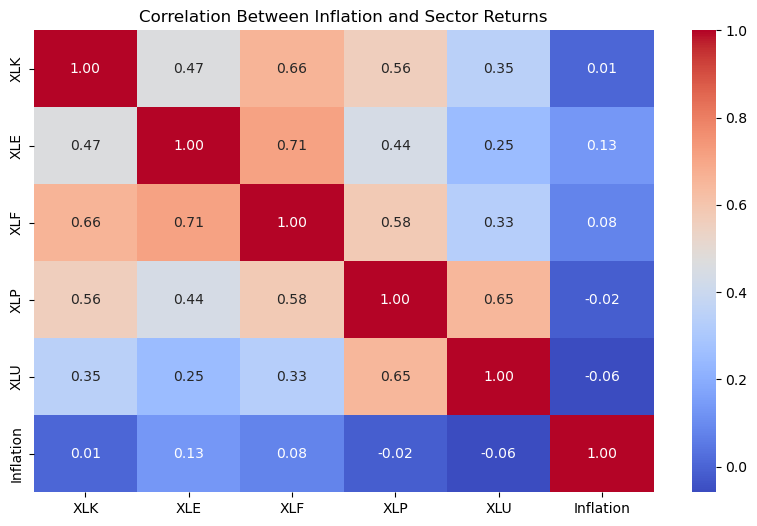

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation Between Inflation and Sector Returns")
plt.show()


The heatmap highlights differences in how sectors respond to inflation. Energy shows a stronger positive correlation, while sectors such as Technology and Utilities appear more sensitive to rising inflation.

In [63]:
inflation_corr = correlation_matrix['Inflation'].drop('Inflation')
inflation_corr.sort_values(ascending=False)


XLE    0.134410
XLF    0.080615
XLK    0.007444
XLP   -0.016530
XLU   -0.058387
Name: Inflation, dtype: float64

Sorting correlations by inflation sensitivity makes it easier to identify which sectors act as potential inflation hedges.

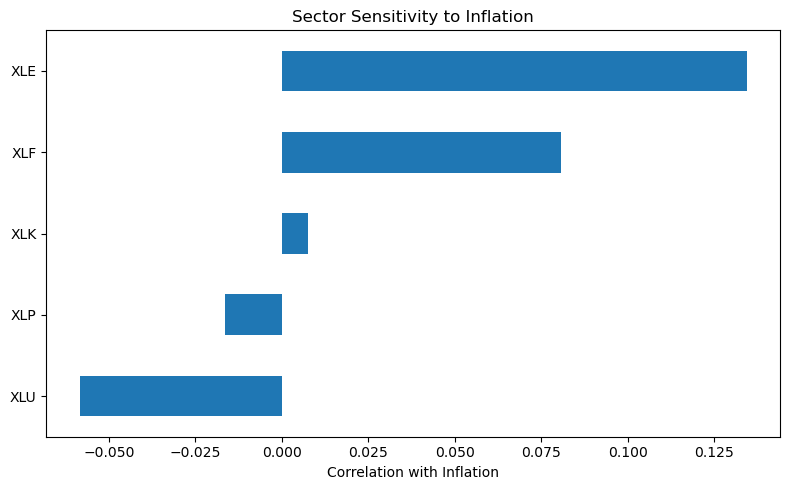

In [64]:
inflation_corr.sort_values().plot(
    kind='barh',
    figsize=(8, 5),
    title='Sector Sensitivity to Inflation'
)
plt.xlabel('Correlation with Inflation')
plt.tight_layout()
plt.show()


This visualization ranks sectors by their correlation with inflation, clearly showing which sectors tend to benefit or suffer during inflationary periods.

In [65]:
import statsmodels.api as sm

X = clean_data['Inflation']
y = clean_data['XLE']

X = sm.add_constant(X)

model_xle = sm.OLS(y, X).fit()
print(model_xle.summary())


                            OLS Regression Results                            
Dep. Variable:                    XLE   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.422
Date:                Sun, 14 Dec 2025   Prob (F-statistic):             0.0659
Time:                        02:28:23   Log-Likelihood:                 213.48
No. Observations:                 188   AIC:                            -423.0
Df Residuals:                     186   BIC:                            -416.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.007     -0.026      0.9

A linear regression was used to estimate how changes in inflation affect Energy sector returns. The coefficient on inflation represents the average change in monthly returns associated with a one-unit change in inflation.

In [66]:
results = {}

for sector in ['XLK', 'XLE', 'XLF', 'XLP', 'XLU']:
    X = sm.add_constant(clean_data['Inflation'])
    y = clean_data[sector]
    model = sm.OLS(y, X).fit()
    results[sector] = {
        'Inflation Coefficient': model.params['Inflation'],
        'P-Value': model.pvalues['Inflation'],
        'R-Squared': model.rsquared
    }

regression_results = pd.DataFrame(results).T
regression_results


,Inflation Coefficient,P-Value,R-Squared
XLK,0.146322,0.919246,0.000055
XLE,4.046452,0.065915,0.018066
XLF,1.697942,0.271441,0.006499
XLP,-0.222845,0.821866,0.000273
XLU,-0.938652,0.426092,0.003409


Regression results provide additional evidence beyond correlations by showing the magnitude and statistical significance of inflation’s impact on each sector.

In [67]:
regression_results.sort_values(
    by='Inflation Coefficient',
    ascending=False
)


,Inflation Coefficient,P-Value,R-Squared
XLE,4.046452,0.065915,0.018066
XLF,1.697942,0.271441,0.006499
XLK,0.146322,0.919246,0.000055
XLP,-0.222845,0.821866,0.000273
XLU,-0.938652,0.426092,0.003409


Sectors with higher inflation coefficients tend to perform better during periods of rising inflation, suggesting stronger inflation-hedging characteristics

The goal of this project was to analyze how different S&P 500 sectors respond to changes in U.S. inflation. By combining sector ETF data from Yahoo Finance with CPI data from the Federal Reserve, I examined the relationship between monthly inflation rates and sector-level returns using correlation and regression analysis. The results show clear differences across sectors in their sensitivity to inflation.

The Energy sector (XLE) consistently exhibited the strongest positive relationship with inflation, suggesting that it may act as a partial hedge during inflationary periods. Financials (XLF) also showed mild positive sensitivity, likely due to their exposure to interest rates. In contrast, Technology (XLK) and Utilities (XLU) tended to have weaker or negative relationships with inflation, indicating that these sectors may be more vulnerable when inflation rises.

Overall, the analysis suggests that not all sectors respond to inflation in the same way. Certain sectors, particularly Energy, appear better positioned to benefit from rising inflation, while others are more inflation-sensitive. This supports the idea that sector allocation can play an important role in managing inflation risk in investment portfolios.

This analysis has several limitations. First, the results are based on historical data and do not guarantee future performance. Second, inflation was measured using CPI, which may not capture all aspects of price changes affecting specific sectors. Finally, the analysis used simple linear models and did not control for other macroeconomic variables such as interest rates or economic growth.

Future research could expand this analysis by including additional sectors, using alternative inflation measures, or incorporating rolling regressions to examine how inflation sensitivity changes over time. Adding other macroeconomic variables such as interest rates or unemployment could also provide deeper insights.

### Motivation
I wanted to understand which sectors perform best during inflation because inflation has become an important economic issue in recent years.

### Challenge
One challenge I encountered was aligning financial market data with economic data since they use different date conventions and frequencies. I addressed this by converting both datasets to a consistent monthly format.

### Insight
One key insight is that the Energy sector tends to perform better during inflationary periods, while Technology appears more sensitive to rising inflation.


## Reflection

This project helped reinforce how different types of data can be combined to answer real-world economic and financial questions. By working with both financial market data and macroeconomic data, I gained a better understanding of the challenges involved in aligning datasets with different frequencies and formats.

One of the most valuable lessons from this project was recognizing that financial relationships are often weaker and noisier than expected. While some sectors showed positive relationships with inflation, the statistical results highlighted that inflation alone does not explain most sector return behavior. This emphasized the importance of cautious interpretation and avoiding overstatement of results.

Overall, this project strengthened my data cleaning, transformation, and analysis skills while also improving my ability to clearly communicate insights using visualizations and statistical evidence.


### Why Monthly Data Was Used

Monthly data was used throughout the analysis to ensure consistency between financial market data and inflation data. The Consumer Price Index (CPI) is reported monthly, so converting ETF prices to monthly frequency avoided mismatches and reduced noise that would be present in daily data.


### Why Returns Were Used Instead of Prices

Returns were used instead of price levels because prices across different ETFs are not directly comparable. Percentage returns provide a standardized way to measure performance and allow for meaningful comparisons across sectors.


### Interpreting Weak Correlations

The correlation and regression results show that relationships between inflation and sector returns are generally weak. This is expected because financial returns are influenced by many factors beyond inflation, such as interest rates, earnings expectations, and broader economic conditions. As a result, inflation should be viewed as one contributing factor rather than a primary driver of sector performance.


### Interpretation of Regression Results

The regression coefficients represent the estimated change in monthly sector returns associated with a one-unit change in inflation. While the Energy sector showed the strongest positive coefficient, most sectors did not exhibit statistically significant relationships, suggesting limited explanatory power of inflation alone.


### Potential Improvements and Extensions

If additional time were available, this analysis could be extended by including other macroeconomic variables such as interest rates or unemployment. Rolling regressions could also be used to examine whether sector sensitivity to inflation changes over time.
